# Predict whether or not a tweet is about a real disaster 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Data Overview

There are 7,613 training data points and 3,263 test datapoints

In [2]:
def df_shape(filename):
    """
        Return the shape (row,columns) of the dataset in the .csv file
        
        @P: filename (string) of a csv data set file
        @R: tuple of dataframe size
        
    """
    df=pd.read_csv(filename)
    return df.shape

def hist_rel_freq(filename,columnName,mx_val):
    """
        Save a relative frequency of a specific column
        
        @P: filename: (csv) the training data file
            columnName: (dtring) the name of the column of interest
            mx_val: (int) the max range for the x-axis
            
    """
    df=pd.read_csv(filename)
    fig, ax = plt.subplots()
    g=sns.histplot(data=df, x=columnName, stat="percent", discrete=True, ax=ax)
    ax.set_xlim(-1,mx_val+1)
    ax.set_xticks(range(0,mx_val+1))
    plt.savefig('output/dist_{}.png'.format(columnName))
    print("\n Column: {} Relative Frequency \n".format(columnName),df[columnName].value_counts(normalize=True))

The shape of the training data is (7613, 5) 
The shape of the test data is (3263, 4) 

 Column: target Relative Frequency 
 0    0.57034
1    0.42966
Name: target, dtype: float64


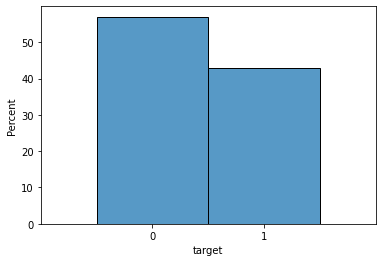

In [3]:
print("The shape of the training data is {} ".format(df_shape("input/train.csv")))
print("The shape of the test data is {} ".format(df_shape("input/test.csv")))
hist_rel_freq("input/train.csv","target",1)

# Split Training Data

In [4]:
df=pd.read_csv("input/train.csv")

X=df.drop('target', axis=1, inplace=False)
y=df['target']
X_train, X_validate, y_train, y_validate = train_test_split(df, y, test_size=0.3, random_state=42)

# Pre-process

• Convert all the words to lowercase

• Lemmatize all thewords (i.e., convert every word to its root so that all of “running,” “run,” and “runs” are converted to “run” and and all of “good,” “well,” “better,” and “best” are converted to “good”; this is easily done using nltk.stem) - (CHOSE NOT TO LEMMATIZE, TO PRESERVE MEANING OF TEXT - CONSIDER WRITING MY OWN FUNCTION)

• Strip punctuation

• Strip the stop words, e.g., “the”, “and”, “or” (ADDITIONAL STOP WORDS?)

• Strip @ and urls (It’s Twitter.)

• Something else? Tell us about it (SPELL CHECK)

In [5]:
def make_lower(col_name,dataF):
    """
        Convert all words to lowercase.
        
        @P: 
        col (string): Name of column in a dataframe that contains text data
        dataF (dataframe): Dataframe with the text data that needs modifying
        
    """
    dataF[col_name]=dataF[col_name].str.lower()
    
def remove_punctuation(col_name,dataF):
    """
        Remove the punctuation in a column with text data.
        
        @P: 
        col (string): Name of column in a dataframe that contains text data
        dataF (dataframe): Dataframe with the text data that needs modifying
        
    """
    
    #Regex to identify anything that is not a word or string
    dataF[col_name]=dataF[col_name].str.replace(r'[^\w\s]+','') 

def remove_tag(txt_col):
    """
        Remove the @'username' in a column with text data.
        
        @P: 
        txt_col (series): Dataframe column that contains text data.
        
        @R:
        s (string): String without @'username'.
        
    """
    words = word_tokenize(txt_col)
    
    j=-1
    w_arr=[]
    for i in range(len(words)):
        if words[i]=='@': j=i+1
        
        if words[i]!='@' and i!=j: w_arr.append(words[i])
    
    s=" ".join(w_arr)
    return s

def remove_url(txt_col):
    """
        Remove the url in a column with text data.
        
        @P: 
        txt_col (series): Dataframe column that contains text data.
        
        @R:
        s (string): String without url.
        
    """
    words = word_tokenize(txt_col)
    w_arr=[ w for w in words if not w.startswith('http')]
    s=" ".join(w_arr)
    return s

def lematize_txt(txt_col):
    """
        Stem words.
        
        @P: 
        txt_col (series): Dataframe column that contains text data.
        
        @R:
        s (string): String of lematized text
        
    """
    
    ps = PorterStemmer()
    words = word_tokenize(txt_col)
    w_arr=[ps.stem(w) for w in words]
    s=" ".join(w_arr)
    return s

def rmv_stop_wrds(txt_col):
    """
        Remove stop words.
        
        @P: 
        txt_col (series): Dataframe column that contains text data.
        
        @R:
        s (string): String of text without stop words.
        
    """
    
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(txt_col)
    w_arr=[w for w in words if not w.lower() in stop_words]
    s=" ".join(w_arr)
    return s

In [6]:
make_lower("text",df)
df['text'] = df.apply(lambda x: remove_tag(x['text']),axis=1)
remove_punctuation("text",df)
df['text'] = df.apply(lambda x: rmv_stop_wrds(x['text']),axis=1)
df['text'] = df.apply(lambda x: remove_url(x['text']),axis=1)

df.to_csv("output/ck_pre_proc.csv")